## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi, drawCMS

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6'
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
lumi = 23.02*1000

if data_year == 2022:
    fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    
for k, T in tree.items():
    branch_names = T.keys()

In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}

cscClusterNStation = {}
cscClusterDphi = {}
nCscClusters = {}

#Study trigger categories:
cscClusterTimeTr1 = {}
cscClusterTimeTr2 = {}
cscClusterTimeTr3 = {}
cscClusterEtaTr1 = {}
cscClusterEtaTr2 = {}
cscClusterEtaTr3 = {}
cscClusterNStationTr1 = {}
cscClusterNStationTr2 = {}
cscClusterNStationTr3 = {}
cscClusterSizeTr1 = {}
cscClusterSizeTr2 = {}
cscClusterSizeTr3 = {}

#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


## Settings

In [4]:
category = 0#-1#0
category = 2
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True

plot_string = ""
#plot_string = "_jet_veto"
#plot_string = "_csc_time_spread_cut"
#plot_string = "_csc_in_time_cut"
#plot_string = ""
#plot_string = "_ME_veto"
#plot_string = "_ME_veto_HLT_eta_cut"
#plot_string = "_ME_veto_HLT_eta_cut_at_least_1_cluster"
#plot_string = "_ME_veto_HLT_eta_cut_in_time_cut_at_least_1_cluster"
#plot_string+= "_exactly_1_csc_cluster"

#plot_string+= "_exactly_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_csc_dt_cluster_ME_veto"
plot_string+= "_csc_dt_cluster_ME_MB_veto"

In [5]:
for a in branch_names:
    #if "MB1" in str(a):
    #    print(a)
    if "Station" in str(a):
        print(a)

b'cscRechitClusterNStation10'
b'cscRechitClusterAvgStation10'
b'cscRechitClusterMaxStation'
b'cscRechitClusterMaxStationRatio'
b'dtRechitClusterNSegStation1'
b'dtRechitClusterNSegStation2'
b'dtRechitClusterNSegStation3'
b'dtRechitClusterNSegStation4'
b'dtRechitClusterNOppositeSegStation1'
b'dtRechitClusterNOppositeSegStation2'
b'dtRechitClusterNOppositeSegStation3'
b'dtRechitClusterNOppositeSegStation4'
b'dtRechitClusterNoiseHitStation1'
b'dtRechitClusterNoiseHitStation2'
b'dtRechitClusterNoiseHitStation3'
b'dtRechitClusterNoiseHitStation4'
b'dtRechitClusterNStation10'
b'dtRechitClusterAvgStation10'
b'dtRechitClusterMaxStation'
b'dtRechitClusterMaxStationRatio'
b'dtRechitClusterNHitStation1'
b'dtRechitClusterNHitStation2'
b'dtRechitClusterNHitStation3'
b'dtRechitClusterNHitStation4'


In [6]:
for k, T in tree.items():
    tree_keys.append(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
########### SELECTION: CLUSTERS ############
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = jet_veto_csc
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_not(jet_veto_csc)       

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    
        

    
    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'Time')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'Time') > -5))

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )      

    
    
    
    
    #Try to understand if some categories have a different resolution in time
    #Trigger cat1
    sel_trgCluster_tr1 = np.logical_and( T.array('cscRechitClusterSize') >= 100, np.logical_and(T.array('cscRechitClusterNStation10')>=2, np.abs(T.array('cscRechitClusterEta'))<1.9))
    #Trigger cat2
    sel_trgCluster_tr2 = np.logical_and( T.array('cscRechitClusterSize') >= 200, np.logical_and(T.array('cscRechitClusterNStation10')==1, np.abs(T.array('cscRechitClusterEta'))<1.9))
    #Trigger cat3    
    sel_trgCluster_tr3 = np.logical_and( T.array('cscRechitClusterSize') >= 500, np.abs(T.array('cscRechitClusterEta'))>=1.9)
    
    sel_trgCluster = np.logical_and( T.array('cscRechitClusterSize') >= 100, np.logical_and(T.array('cscRechitClusterNStation10')>=2, np.abs(T.array('cscRechitClusterEta'))<1.9))
    sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 200, np.logical_and(T.array('cscRechitClusterNStation10')==1, np.abs(T.array('cscRechitClusterEta'))<1.9)))
    sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 500, np.abs(T.array('cscRechitClusterEta'))>=1.9))
    
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   ) 
    if do_HLT_eta_cut:
        sel_csccluster = np.logical_and(sel_csccluster,sel_trgCluster)

        
        
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)
        
    #Check with Christina:
    #These selections ensure there are no clusters with hits in 4 DT stations to reduce muon background
    #MB1 veto was not applied in Run2 double tag
    #But we apply it now since it's present at HLT --> no need to implement this on top
    '''
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    cut = 5
    station = (T.array('dtRechitClusterNSegStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4))
    '''
    
    #print(max_station)
    #print(sel_dtcluster)
    
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose

    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    #sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #If trigger:
    #We don't have correct trigger emulation in signal at the moment
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    
    ##print("Events passing so far: ", sel_ev[k].sum())
    #sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    #sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    ##print("Events passing so far: ", sel_ev[k].sum())
    



    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
        #Adding this to avoid overlaps as a starting point
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])       
    #break
########### BRANCHES ############
    ##### event variables #####
    #gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]

    if category == 0 or category==-1 or category==1:
        cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
        #cscRechitClusterDphi1[k] =  T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_csccluster][sel_ev[k]][:,:]
        #cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]]  
        cscClusterSize2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 1)  ][:,:]
        cscClusterTime2[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 1)  ][:,:]
        cscClusterEta2[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 1)  ][:,:]
        
        cscClusterSize3[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 2)  ][:,:]
        cscClusterTime3[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 2)  ][:,:]
        cscClusterEta3[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][ np.logical_and(sel_ev[k],sel_csccluster.sum() > 2)  ][:,:]

        cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
        cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]        
        
        cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
        nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
        nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]

        
        sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
        #Separate in trigger categories
        cscClusterTimeTr1[k] = T.array('cscRechitCluster' + cluster_index + 'Time')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterTimeTr2[k] = T.array('cscRechitCluster' + cluster_index + 'Time')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterTimeTr3[k] = T.array('cscRechitCluster' + cluster_index + 'Time')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]
        cscClusterEtaTr1[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterEtaTr2[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterEtaTr3[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]
        cscClusterNStationTr1[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterNStationTr2[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterNStationTr3[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]
        cscClusterSizeTr1[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[np.logical_and(sel_csccluster,sel_trgCluster_tr1)][sel_ev[k]][:,:]
        cscClusterSizeTr2[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[np.logical_and(sel_csccluster,sel_trgCluster_tr2)][sel_ev[k]][:,:]
        cscClusterSizeTr3[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[np.logical_and(sel_csccluster,sel_trgCluster_tr3)][sel_ev[k]][:,:]

        hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
        sel_ev[k] = sel_ev[k][ sel_ev[k] ]        

    elif category == 2:
        dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
        dtClusterNHitStation1[k] = T.array('dtRechitClusterNHitStation1')[sel_dtcluster][sel_ev[k]][:,:]
        dtCluster_match_MB1hits_0p4[k] = T.array('dtRechitCluster_match_MB1hits_0p4')[sel_dtcluster][sel_ev[k]][:,:]
        dtCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_dtcluster][sel_ev[k]][:,:]
        
        
        cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
        cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
        cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
        nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
        nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
        
        
        sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
        sel_jetveto_dt[k] = jet_veto_dt[sel_dtcluster][sel_ev[k]][:,:]
        sel_muonveto_dt[k] = muon_veto_dt[sel_dtcluster][sel_ev[k]][:,:]        
        #This gives some errors...
        #nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]

        #To be fixed, some issues with deltaPhi function
        #deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
        #deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]

        dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
        
        hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
        sel_ev[k] = sel_ev[k][ sel_ev[k] ]

    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))



## General histograms

Compare dtRechitClusterNHitsStation1 and dtRechitCluster_match_MB1hits_0p4 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

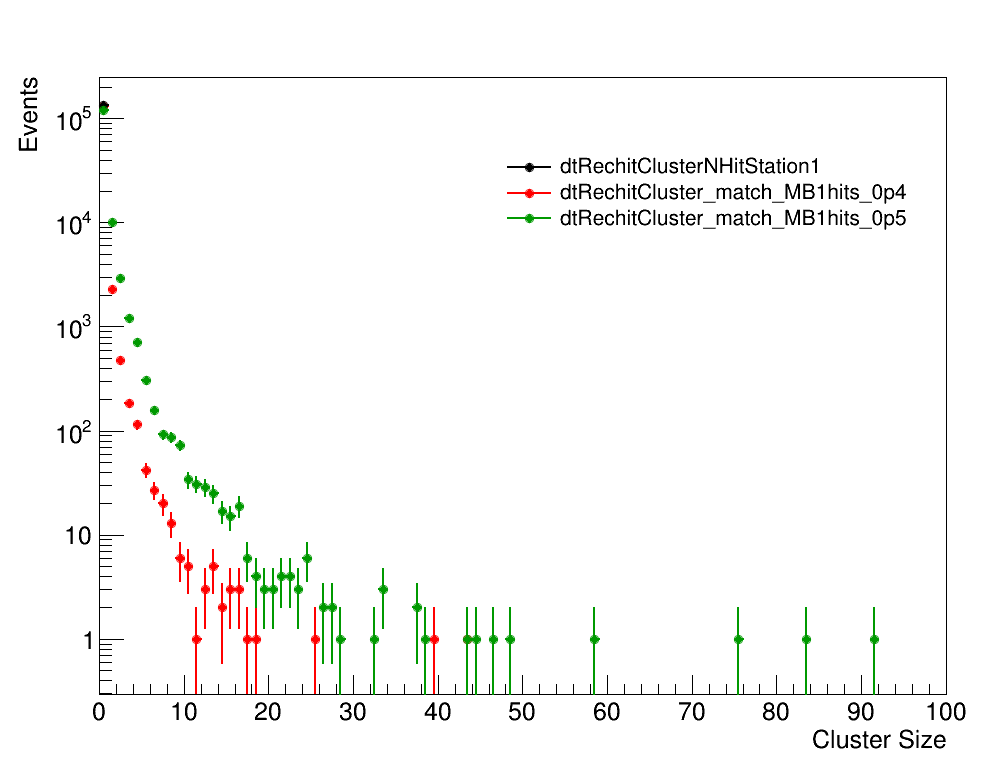

In [7]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.7,0.75,0.8)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
for k in tree_keys:
    h0[k] = create_TH1D(dtClusterNHitStation1[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,100])
    leg.AddEntry(h0[k],"dtRechitClusterNHitStation1")
    h0[k].SetLineColor(1)
    h0[k].SetLineWidth(2)
    h0[k].SetMarkerColor(1)
    h0[k].SetMarkerStyle(20)
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h1[k] = create_TH1D(dtCluster_match_MB1hits_0p4[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,100])
    leg.AddEntry(h1[k],"dtRechitCluster_match_MB1hits_0p4")
    h1[k].SetLineColor(2)
    h1[k].SetLineWidth(2)
    h1[k].SetMarkerColor(2)
    h1[k].SetMarkerStyle(20)
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    #h[k].SetMaximum(1.5)
    #h[k].SetMinimum(0.002)

    h2[k] = create_TH1D(dtCluster_match_MB1hits_0p5[k].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,100])
    leg.AddEntry(h2[k],"dtRechitCluster_match_MB1hits_0p5")
    h2[k].SetLineColor(418)
    h2[k].SetLineWidth(2)
    h2[k].SetMarkerColor(418)
    h2[k].SetMarkerStyle(20)
    h2[k].SetMarkerSize(1.2)
    
    h1[k].Draw('PE same')        
    h0[k].Draw('PE same')
    h2[k].Draw('PE same')

    
leg.Draw()
can.SetRightMargin(0.05)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/DtClusterRecHitsStation1"+plot_string+".pdf")
can.Print("plots/V1p19_"+vers+"/DtClusterRecHitsStation1"+plot_string+".png")

# L1 and HLT plateau

In [8]:
L1_plateau = {}
HLT_plateau = {}

sel_trgCluster_tr1 ={}
sel_trgCluster_tr2 ={}
sel_trgCluster_tr3 ={}

sel_trgCluster_tr1_minus_size ={}
sel_trgCluster_tr2_minus_size ={}
sel_trgCluster_tr3_minus_size ={}

sel_HLT_OR = {}

first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_fired_L1 = {}

first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}


first_fired_HLT = {} 
first_fired_HLT_tr1 = {}
first_fired_HLT_tr2 = {}
first_fired_HLT_tr3 = {}

for k in tree_keys:
    #OR over the two clusters
    sel_trgCluster_tr1[k] = np.logical_and( cscClusterSize[k] >= 100, np.logical_and(cscClusterNStation[k]>=2, np.abs(cscClusterEta[k])<1.9))
    sel_trgCluster_tr2[k] = np.logical_and( cscClusterSize[k] >= 200, np.logical_and(cscClusterNStation[k]==1, np.abs(cscClusterEta[k])<1.9))   
    sel_trgCluster_tr3[k] = np.logical_and( cscClusterSize[k] >= 500, np.abs(cscClusterEta[k])>=1.9)

    sel_trgCluster_tr1_minus_size[k] = np.logical_and(cscClusterNStation[k]>=2, np.abs(cscClusterEta[k])<1.9)
    sel_trgCluster_tr2_minus_size[k] = np.logical_and(cscClusterNStation[k]==1, np.abs(cscClusterEta[k])<1.9)  
    sel_trgCluster_tr3_minus_size[k] = np.abs(cscClusterEta[k])>=1.9

    sel_HLT_OR[k] = np.logical_or(sel_trgCluster_tr1[k],np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k]))
    
    #Event level
    L1_plateau[k] = ((cscClusterSize[k] >= 200).any()==True)
    HLT_plateau[k] = np.logical_or( sel_trgCluster_tr1[k] , np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k])  ).any()==True

    #First cluster specific    
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = (first_in_ME22[k]) & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]
    
    print(HLT_plateau[k].shape)
    print(sel_ev[k].shape)
    print(cscClusterSize[k].shape)
    print(first_in_ME22[k])
    print(first_in_plateau_ME22[k])

(135014,)
(135014,)
(135014,)
[False False False ... False False False]
[False False False ... False False False]


## Effect of CSC being in more than one station

Look at smoothness of DT

In [9]:
dict_ME = {}
dict_ME["ME11"] = first_in_plateau_ME11
dict_ME["ME12"] = first_in_plateau_ME12
dict_ME["ME13"] = first_in_plateau_ME13
dict_ME["ME21"] = first_in_plateau_ME21
dict_ME["ME22"] = first_in_plateau_ME22
dict_ME["ME31"] = first_in_plateau_ME31
dict_ME["ME32"] = first_in_plateau_ME32
dict_ME["ME41"] = first_in_plateau_ME41
dict_ME["ME42"] = first_in_plateau_ME42
dict_ME["all"]  = first_in_plateau

In [10]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau")
            cut = dict_ME[m][k]
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau")
            cut = dict_ME[m][k]
            lab = ""
    
        h0[k] = create_TH1D(cscClusterSize[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
        leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h1[k] = create_TH1D(dtClusterSize[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
        leg.AddEntry(h1[k],"DT")
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h1[k].Draw('PE same')        
        h0[k].Draw('PE same')

        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_in_plateau"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_in_plateau"+lab+plot_string+".png")
        can.Close()
        h1[k].Delete()
        h0[k].Delete()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [29]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau")
            cut = dict_ME[m][k]
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau")
            cut = dict_ME[m][k]
            lab = ""
    
        tmp_csc_eta = cscClusterEta[k][ cut ][:,0].flatten()
        tmp_csc_phi = cscClusterPhi[k][ cut ][:,0].flatten()
        tmp_dt_eta = dtClusterEta[k][ cut ][:,0].flatten()
        tmp_dt_phi = dtClusterPhi[k][ cut ][:,0].flatten()
        dR = deltaR(tmp_csc_eta, tmp_csc_phi, tmp_dt_eta, tmp_dt_phi)
        h0[k] = create_TH1D(dR,title="",axis_title = ['CSC-DT cluster #Delta R','Events'], binning=[100,0,4])
        #leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h0[k].Draw('PE same')
        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscDt_dR_in_plateau"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscDt_dR_in_plateau"+lab+plot_string+".png")
        can.Close()
        h0[k].Delete()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [17]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau")
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau")
            lab = ""
    
        cut = dict_ME[m][k]
        h0[k] = create_TH1D(cscClusterNStation[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster n. station','Events'], binning=[4,0.5,4.5])
        leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
     
        h0[k].Draw('PE same')

        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscNStation_in_plateau"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscNStation_in_plateau"+lab+plot_string+".png")
        can.Close()
        h0[k].Delete()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [26]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau, 1 station")
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau, 1 station")
            lab = ""
    
        cut = dict_ME[m][k] & (cscClusterNStation[k][:,0]==1)
        #print(cut[cut])
        #print(cscClusterSize[k][ cut ][:,0])
        #print(cscClusterNStation[k][cut][:,0])
        #print(dtClusterSize[k][ cut ][:,0])
        h0[k] = create_TH1D(cscClusterSize[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
        leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h1[k] = create_TH1D(dtClusterSize[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
        leg.AddEntry(h1[k],"DT")
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h1[k].Draw('PE same')        
        h0[k].Draw('PE same')

        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_in_plateau_one_station"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_in_plateau_one_station"+lab+plot_string+".png")
        can.Close()
        h1[k].Delete()
        h0[k].Delete()        

[]
[]
[]
[]
[]
[]
[]
[]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  T

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

[ True  True  True ...  True  True  True]
[ 215  518 1029 ...  380  457  399]
[1 1 1 ... 1 1 1]
[ 66 224 385 ...  88  77  74]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[ 741  781  628  881  876  631  859  624  573  533 1537  593  899  732
  967  917  905  624  631  946  804  565  695  937 1360  686  513  655
  847 1407  635  770  600  598  867 1088  609  616  517  980  660  608
  779 1395  716]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[118  89  75 134  58  57  62  65  51  96 139  51  52  75  83  59  76 158
 181  57  85  95  66  67 100  85  87  61  58  54  54  55  69  62  64  55
  75  71  55  55 117  67 166  53 127]
[ True  True  True ...  True  True  True]
[402 351 284 ... 211 246 378]
[1 1 1 ... 1 1 1]
[ 

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[ 715  744 1140  770 1411  900 1024  855 3004  628  563  813  918  842
  668 1602  614  547 1597  620 4178  884 1471  622 1559 1332  549 2426
  894  609  701  715  547  578  545  632  805 1381  620  512  845  951
 1885 1117  682  842 1245]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[ 66 170  54 176  62  52  89  85 100  56  80  70  62 183 129  70  84  52
  63 309 144  53  54 119 228  92  57  88  72  60 123 164  57  92  78  96
  53  54 299  82 128 153  79 115  96  56  67]
[ True  True  True ...  True  True  True]
[202 205 214 ... 410 203 210]
[1 1 1 ... 1 1 1]
[ 91  69  55 ...  80  68 338]
[ True  True  True ...  True  True  True]
[215 202 402 ... 246 3

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [30]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau, 1 station")
            cut = dict_ME[m][k] & (cscClusterNStation[k][:,0]==1)
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau, 1 station")
            cut = dict_ME[m][k] & (cscClusterNStation[k][:,0]==1)
            lab = ""
    
        tmp_csc_eta = cscClusterEta[k][ cut ][:,0].flatten()
        tmp_csc_phi = cscClusterPhi[k][ cut ][:,0].flatten()
        tmp_dt_eta = dtClusterEta[k][ cut ][:,0].flatten()
        tmp_dt_phi = dtClusterPhi[k][ cut ][:,0].flatten()
        dR = deltaR(tmp_csc_eta, tmp_csc_phi, tmp_dt_eta, tmp_dt_phi)
        h0[k] = create_TH1D(dR,title="",axis_title = ['CSC-DT cluster #Delta R','Events'], binning=[100,0,4])
        #leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h0[k].Draw('PE same')
        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscDt_dR_in_plateau_one_station"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscDt_dR_in_plateau_one_station"+lab+plot_string+".png")
        can.Close()
        h0[k].Delete()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [27]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau, >1 station")
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau, >1 station")
            lab = ""
    
        cut = dict_ME[m][k] & (cscClusterNStation[k][:,0]>1)
        h0[k] = create_TH1D(cscClusterSize[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
        leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h1[k] = create_TH1D(dtClusterSize[k][ cut ][:,0].flatten(),title="",axis_title = ['Cluster Size','Events'], binning=[100,0,1000])
        leg.AddEntry(h1[k],"DT")
        h1[k].SetLineColor(2)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(2)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h1[k].Draw('PE same')        
        h0[k].Draw('PE same')

        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_in_plateau_more_one_station"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscDtClusterSize_in_plateau_more_one_station"+lab+plot_string+".png")
        can.Close()
        h1[k].Delete()
        h0[k].Delete()

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

In [31]:
for k in tree_keys:
    
    for m in dict_ME.keys():
        
        can = rt.TCanvas('c','c', 1000, 800)
        leg = rt.TLegend(0.5,0.7,0.75,0.8)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        h0 = {}
        h1 = {}
        h2 = {}
        can.cd()
        scale=False

        if m!="all":
            leg.SetHeader("First CSC cluster in "+m+" L1/HLT plateau, >1 station")
            cut = dict_ME[m][k] & (cscClusterNStation[k][:,0]>1)
            lab = "_"+m
        else:
            leg.SetHeader("First CSC cluster in L1/HLT plateau, >1 station")
            cut = dict_ME[m][k] & (cscClusterNStation[k][:,0]>1)
            lab = ""
    
        tmp_csc_eta = cscClusterEta[k][ cut ][:,0].flatten()
        tmp_csc_phi = cscClusterPhi[k][ cut ][:,0].flatten()
        tmp_dt_eta = dtClusterEta[k][ cut ][:,0].flatten()
        tmp_dt_phi = dtClusterPhi[k][ cut ][:,0].flatten()
        dR = deltaR(tmp_csc_eta, tmp_csc_phi, tmp_dt_eta, tmp_dt_phi)
        h0[k] = create_TH1D(dR,title="",axis_title = ['CSC-DT cluster #Delta R','Events'], binning=[100,0,4])
        #leg.AddEntry(h0[k],"CSC")
        h0[k].SetLineColor(1)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(1)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())
        #h[k].SetMaximum(1.5)
        #h[k].SetMinimum(0.002)

        h0[k].Draw('PE same')
        leg.Draw()
        can.SetRightMargin(0.05)
        drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

        # if setlog: 
        can.SetLogy()
        can.Draw()
        can.Print("plots/V1p19_"+vers+"/CscDt_dR_in_plateau_more_one_station"+lab+plot_string+".pdf")
        can.Print("plots/V1p19_"+vers+"/CscDt_dR_in_plateau_more_one_station"+lab+plot_string+".png")
        can.Close()
        h0[k].Delete()        

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

* Check if HLT bit is correct
* Split in different CSC categories --> there are kinks...